In [1]:
!pip install torch
!pip install torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [3]:
# Convolutional VAE Architecture
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # Output: 32x16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: 64x8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: 128x4x4
            nn.ReLU(),
            nn.Flatten()  # Output: 128 * 4 * 4 = 2048
        )

        self.fc_mu = nn.Linear(2048, latent_dim)
        self.fc_logvar = nn.Linear(2048, latent_dim)

        # Decoder
        self.decoder_fc = nn.Linear(latent_dim, 2048)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: 64x8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: 32x16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # Output: 3x32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z)
        h = h.view(-1, 128, 4, 4)  # Reshape to match the input of the first transposed conv layer
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [4]:

# Loss function
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [5]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [6]:
# Load CIFAR-10 dataset
transform = transforms.ToTensor()
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Initialize the Convolutional VAE
latent_dim = 128
conv_vae = ConvVAE(latent_dim=latent_dim)
optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

# Train the Convolutional VAE
for epoch in range(1, 11):
    train(conv_vae, train_loader, optimizer, epoch)


100%|██████████| 170M/170M [00:11<00:00, 14.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch 1, Loss: 1935.2392428125
Epoch 2, Loss: 1851.9347115625
Epoch 3, Loss: 1838.2683765625
Epoch 4, Loss: 1832.59214875
Epoch 5, Loss: 1829.1384209375
Epoch 6, Loss: 1826.2924646875
Epoch 7, Loss: 1824.581994375
Epoch 8, Loss: 1823.5424584375
Epoch 9, Loss: 1822.4302153125
Epoch 10, Loss: 1821.68611125


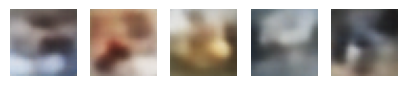

In [7]:
# Function to generate and display new images
def generate_images(model, num_images=10, latent_dim=128):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for generation
        # Sample random points from the latent space (standard normal distribution)
        z = torch.randn(num_images, latent_dim)
        # Decode these points to generate images
        generated_images = model.decode(z).cpu()

    # Plot the generated images
    fig, axs = plt.subplots(1, num_images, figsize=(num_images, 1.5))
    for i in range(num_images):
        # Reshape to (3, 32, 32) and then permute to (32, 32, 3) for imshow
        axs[i].imshow(generated_images[i].permute(1, 2, 0))
        axs[i].axis('off')
    plt.show()

# Generate and display images from the trained Convolutional VAE
generate_images(conv_vae, num_images=5, latent_dim=latent_dim)

In [8]:
# Function to interpolate between two images in the latent space
def interpolate_images(model, image1, image2, num_interpolations=10):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Turn off gradients for interpolation
        # Encode the two images into their latent representations
        mu1, _ = model.encode(image1.unsqueeze(0))  # Add batch dimension
        mu2, _ = model.encode(image2.unsqueeze(0))  # Add batch dimension

        # Perform linear interpolation between the latent vectors
        interpolated_images = []
        for alpha in np.linspace(0, 1, num_interpolations):
            interpolated_latent = alpha * mu1 + (1 - alpha) * mu2
            interpolated_image = model.decode(interpolated_latent).cpu()
            interpolated_images.append(interpolated_image)

        return interpolated_images

In [9]:
# Function to display interpolated images in a grid
def display_interpolated_images(interpolated_images):
    num_interpolations = len(interpolated_images)
    fig, axs = plt.subplots(1, num_interpolations, figsize=(num_interpolations, 1.5))
    for i, img in enumerate(interpolated_images):
        axs[i].imshow(img.squeeze().permute(1, 2, 0))  # Remove batch dimension and permute for imshow
        axs[i].axis('off')
    plt.show()

In [10]:
# Select two images from the CIFAR-10 test set
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)
image1, _ = test_dataset[0]  # First image in the test set
image2, _ = test_dataset[1]  # Second image in the test set

Files already downloaded and verified


In [12]:
import numpy as np

In [13]:
# Interpolate between the two images
interpolated_images = interpolate_images(conv_vae, image1, image2, num_interpolations=10)

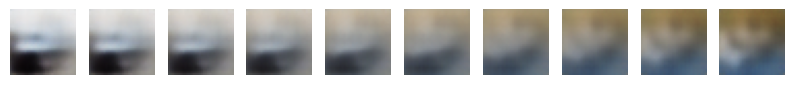

In [14]:
# Display the interpolated images
display_interpolated_images(interpolated_images)